In [8]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn as sb
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
import warnings
warnings.filterwarnings('ignore')
import astropy.coordinates as coord
import astropy.units as u
import corner

## Read in data

In [2]:
with open('../lensed_SN_catalog/Baselinev3_0_doubles.pkl', 'rb') as f:
    doubles = pickle.load(f)
with open('../lensed_SN_catalog/Baselinev3_0_quads.pkl', 'rb') as f:
    quads = pickle.load(f)
with open('../lensed_SN_catalog/Baselinev3_0_unlensed.pkl', 'rb') as f:
    sne = pickle.load(f)
    
print("Doubles: ", len(doubles))
print("Quads: ", len(quads))
print("Unlensed: ", len(sne))

Doubles:  5000
Quads:  5000
Unlensed:  5000


In [3]:
df_ = pd.read_csv('../lensed_SN_catalog/processed_lcs_ana.csv')
mask_microdet_ = (df_.mult_method_micro==1)|np.isnan(df_.mult_method_micro)|(df_.mag_method_micro==1)|np.isnan(df_.mag_method_micro)

df_out_nim2     = df_[(df_.nima==2.0)]                             # Doubles
df_out_nim4     = df_[(df_.nima==4.0)]                             # Quads
df_out_unlensed = df_[(df_['type']=='unlensed')&(df_.nima==1.0)]   # Unlensed
df_out_lensed   = df_[(df_['type']!='unlensed')]                   # All lenses

mask_microdet = (df_out_lensed.mult_method_micro==1)|(df_out_lensed.mag_method_micro==1)  # Mask for detected with microlensing

plots_path = '../results/figures/'

df_out_nim2.keys()

Index(['g_npoints', 'g_rise_time', 'g_rise_rate', 'g_decay_time',
       'g_decay_rate', 'g_peak_mag', 'g_peak_mag_minus7', 'g_peak_mag_plus7',
       'g_peak_mag_minus14', 'g_peak_mag_plus14',
       ...
       'y_peak_mag_plus14_err_micro_abs_zs',
       'y_peak_mag_plus14_err_micro_abs_zl', 'z_lens', 'ima',
       'mult_method_peak', 'mult_method', 'mult_method_micro',
       'mag_method_peak', 'mag_method', 'mag_method_micro'],
      dtype='object', length=562)

## Compute detected sample

In [4]:
dt_doubles, dt_quads = [], []
mutot_doubles, mutot_quads = [], []
peak_i_doubles, peak_i_quads = [], []
peak_r_doubles, peak_r_quads = [], []
peak_z_doubles, peak_z_quads = [], []
peak_y_doubles, peak_y_quads = [], []

for s in range(len(doubles)):
    
    dt_doubles.append(doubles['time_delay'][s][1])
    dt_quads.append(max(quads['time_delay'][s]))
    mutot_doubles.append(np.sum(doubles['macro_mag'][s]))
    mutot_quads.append(np.sum(quads['macro_mag'][s]))
    peak_r_doubles.append(doubles['peak_magnitudes_micro'][s][1])
    peak_r_quads.append(quads['peak_magnitudes_micro'][s][1])
    peak_i_doubles.append(doubles['peak_magnitudes_micro'][s][2])
    peak_i_quads.append(quads['peak_magnitudes_micro'][s][2])
    peak_z_doubles.append(doubles['peak_magnitudes_micro'][s][3])
    peak_z_quads.append(quads['peak_magnitudes_micro'][s][3])
    peak_y_doubles.append(doubles['peak_magnitudes_micro'][s][4])
    peak_y_quads.append(quads['peak_magnitudes_micro'][s][4])
    
dt_doubles = np.array(dt_doubles)
dt_quads = np.array(dt_quads)
mutot_doubles = np.array(mutot_doubles)
mutot_quads = np.array(mutot_quads)
peak_r_doubles = np.array(peak_r_doubles)
peak_r_quads = np.array(peak_r_quads)
peak_i_doubles = np.array(peak_i_doubles)
peak_i_quads = np.array(peak_i_quads)
peak_z_doubles = np.array(peak_z_doubles)
peak_z_quads = np.array(peak_z_quads)
peak_y_doubles = np.array(peak_y_doubles)
peak_y_quads = np.array(peak_y_quads)

In [5]:
# masks

# Rolling / non-rolling
md_nonrol = (doubles['obs_start']) <= 60768
md_rol = (doubles['obs_start']) > 60768
mq_nonrol = (quads['obs_start']) <= 60768
mq_rol = (quads['obs_start']) > 60768

# Survey
md_WFD = (doubles['survey']) == 'WFD'
md_DDF = (doubles['survey']) == 'DDF'
md_gal = (doubles['survey']) == 'galactic plane'
mq_WFD = (quads['survey']) == 'WFD'
mq_DDF = (quads['survey']) == 'DDF'
mq_gal = (quads['survey']) == 'galactic plane'

# Detected
md_detected = (doubles['mag_method'] == True) | (doubles['mult_method'] == True)
md_detected_micro = (doubles['mag_method_micro'] == True) | (doubles['mult_method_micro'] == True)
md_detected_peak = (doubles['mag_method_peak'] == True) | (doubles['mult_method_peak'] == True)
md_nondetect_micro = (doubles['mag_method_micro'] == False) & (doubles['mult_method_micro'] == False)
md_nondetect = (doubles['mag_method'] == False) & (doubles['mult_method'] == False)
mq_detected_micro = (quads['mag_method_micro'] == True) | (quads['mult_method_micro'] == True)
mq_detected = (quads['mag_method'] == True) | (quads['mult_method'] == True)
mq_nondetect_micro = (quads['mag_method_micro'] == False) & (quads['mult_method_micro'] == False)
mq_nondetect = (quads['mag_method'] == False) & (quads['mult_method'] == False)
mq_detected_peak = (quads['mag_method_peak'] == True) | (quads['mult_method_peak'] == True)

md_detected_micro_mag = (doubles['mag_method_micro'] == True)
md_detected_micro_mult = (doubles['mult_method_micro'] == True)
mq_detected_micro_mag = (quads['mag_method_micro'] == True)
mq_detected_micro_mult = (quads['mult_method_micro'] == True)

md_mult_peak = (doubles['mult_method_peak'] == True)
md_mag_peak = (doubles['mag_method_peak'] == True)
mq_mult_peak = (quads['mult_method_peak'] == True)
mq_mag_peak = (quads['mag_method_peak'] == True)

# Minimum time delay
dt_lim = 10
md_dt_lim = dt_doubles > dt_lim
mq_dt_lim = dt_quads > dt_lim

md_thetaE = doubles['theta_E'] > 0.5
mq_thetaE = quads['theta_E'] > 0.5

print("Doubles detected: ", md_detected_micro.sum())
print("Quads detected: ", mq_detected_micro.sum())

Doubles detected:  2057
Quads detected:  3462


## Microlensing impact

In [7]:
micropeak1, micropeak2 = [], []
mpeak1, mpeak2, mpeak3, mpeak4 = [], [], [], []

for i in range(len(doubles)):
    micropeak1.append(doubles['micro_peak'][i][0])
    micropeak2.append(doubles['micro_peak'][i][1])
    mpeak1.append(quads['micro_peak'][i][0])
    mpeak2.append(quads['micro_peak'][i][1])
    mpeak3.append(quads['micro_peak'][i][2])
    mpeak4.append(quads['micro_peak'][i][3])
    
micropeak1 = np.array(micropeak1)
micropeak2 = np.array(micropeak2)


### Figure 8

435 683 3882


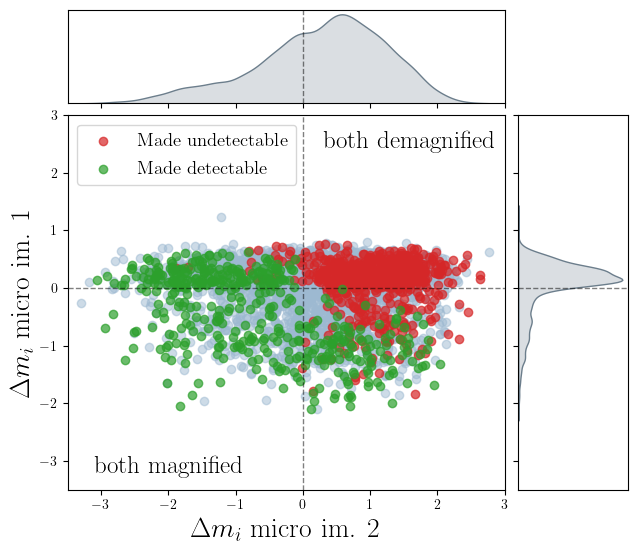

In [9]:
micro_plus = np.where((md_detected_micro) & (md_nondetect))[0]
micro_min = np.where((md_nondetect_micro) & (md_detected))[0]
micro_same = np.where(((md_detected_micro) & (md_detected)) | ((md_nondetect_micro) & (md_nondetect)))
print(len(micropeak1[micro_plus]), len(micropeak1[micro_min]), len(micropeak1[micro_same]))

# Start with a square Figure.
fig = plt.figure(figsize=(7, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

sb.kdeplot(micropeak2, ax=ax_histx, fill=True, color="#6c7e8c", bw_adjust=0.8)
ax_histx.axvline(x=0, color='black', ls='--', lw=1, alpha=0.5)
sb.kdeplot(y=micropeak1, ax=ax_histy, fill=True, color="#6c7e8c", bw_adjust=0.8)
ax_histy.axhline(y=0, color='black', ls='--', lw=1, alpha=0.5)
ax_histx.set_ylabel(" ")
ax_histy.set_xlabel(" ")
ax_histx.tick_params(axis="y", labelbottom=False, left = False, right = False , labelleft = False, bottom = False)
ax_histy.tick_params(axis="x", labelbottom=False, left = False, right = False , labelleft = False, bottom = False)

ax.scatter(micropeak2[micro_same], micropeak1[micro_same], alpha=0.5, color='#9db9d1')
ax.scatter(micropeak2[micro_min], micropeak1[micro_min], color='C3', alpha=0.7, label="Made undetectable")
ax.scatter(micropeak2[micro_plus], micropeak1[micro_plus], color='C2', alpha=0.7, label="Made detectable")
ax.set_xlabel(r"$\Delta m_i$ micro im. 2", fontsize=20)
ax.set_ylabel(r"$\Delta m_i$ micro im. 1", fontsize=20)
ax.axhline(y=0, color='black', ls='--', lw=1, alpha=0.5)
ax.axvline(x=0, color='black', ls='--', lw=1, alpha=0.5)
ax.text(-3.1, -3.2, "both magnified", fontsize=18)
ax.text(0.3, 2.43, "both demagnified", fontsize=18)
ax.set_ylim(-3.5, 3)
ax.set_xlim(-3.5, 3)
ax.legend(loc='upper left', fontsize=13.5)

#plt.savefig("../Results/Figures/Microlensing3_scatterplot_paper.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')